In [1]:
from __future__ import division
import numpy as np
from numpy import sqrt, sin, cos
import copy
import matplotlib.pyplot as plt
from pycbc.waveform import get_fd_waveform

import lal
from lal import PI, MSUN_SI, MTSUN_SI, PC_SI, CreateCOMPLEX8FrequencySeries, CreateREAL8Vector, ResizeCOMPLEX16FrequencySeries
import lalsimulation as lalsim
from lalinspiral import CreateSBankWorkspaceCache, InspiralSBankComputeMatch
from lalinspiral.sbank.psds import noise_models, get_PSD
import wfutils as lsu


def ComputeLALSimFDWaveform(prm, LALParam=None):
    return lalsim.SimInspiralChooseFDWaveform(prm.mass1 * lal.MSUN_SI, prm.mass2 * lal.MSUN_SI,
                0., 0., prm.spin1z, 0., 0., prm.spin2z,
                prm.dist, prm.incl, prm.phiref, 0., 0., 0.,
                prm.deltaF, prm.fmin , prm.fmax, prm.fmin, LALParam, prm.approx)

#what is ASD?
def CalMatch(tmp_prms, inj_prms, ASD):
    # Create workspace for match calculation
    workspace_cache = CreateSBankWorkspaceCache()
    
    inj_hp, inj_hc = ComputeLALSimFDWaveform(inj_prms, LALParam=inj_prms.nonGRparams)    
    if inj_hc.data.length > len(ASD):
        ASD2 = np.ones(inj_hc.data.length) * np.inf
        ASD2[:len(ASD)] = ASD
        ASD = ASD2
    inj_hc.data.data[:int(inj_prms.fmin/inj_prms.deltaF)] = 0.0
    whiten_inj = lal.CreateCOMPLEX8FrequencySeries(inj_hc.name, -1.0, inj_hc.f0, inj_hc.deltaF, inj_hc.sampleUnits, inj_hc.data.length)
    whiten_inj.data.data[:] = inj_hc.data.data[:]/ASD
    whiten_inj.data.data /= float(np.vdot(whiten_inj.data.data, whiten_inj.data.data).real * 4 * inj_hc.deltaF)**0.5

    tmp_hp, tmp_hc = ComputeLALSimFDWaveform(tmp_prms, LALParam=None)
    tmp_hc.data.data[:int(tmp_prms.fmin/tmp_prms.deltaF)] = 0.0
    whiten_tmp = lal.CreateCOMPLEX8FrequencySeries(tmp_hc.name, -1.0, tmp_hc.f0, tmp_hc.deltaF, tmp_hc.sampleUnits, tmp_hc.data.length)
    whiten_tmp.data.data[:] = tmp_hc.data.data[:]/ASD
    whiten_tmp.data.data /= float(np.vdot(whiten_tmp.data.data, whiten_tmp.data.data).real * 4 * tmp_hc.deltaF)**0.5

    return InspiralSBankComputeMatch(whiten_inj, whiten_tmp, workspace_cache)



    

'''

inj_params = copy.deepcopy(lsu.ChooseWaveformParams())
inj_params.mass1 = 16.0
inj_params.mass2 = 6.0
inj_params.spin1z = 0.998
inj_params.spin2z = 0.998
lal_prm = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertNonGRDChi1(lal_prm, 0.6) # maximum 2.5
lalsim.SimInspiralWaveformParamsInsertNonGRDChi2(lal_prm, 0.4) # maximum 5.5 
lalsim.SimInspiralWaveformParamsInsertNonGRDChi3(lal_prm, 0.0) # maximum 5.5
lalsim.SimInspiralWaveformParamsInsertNonGRDChi4(lal_prm, 0.0) # maximum 5.5 

inj_params.nonGRparams = lal_prm

tmp_params = copy.deepcopy(lsu.ChooseWaveformParams())
tmp_params.mass1 = 16.0
tmp_params.mass2 = 6.0
tmp_params.spin1z = 0.998
tmp_params.spin2z = 0.998

PSD = get_PSD(tmp_params.deltaF, inj_params.fmin, inj_params.fmax, noise_models["aLIGOZeroDetHighPower"])
ASD = np.sqrt(PSD)
'''



'\n\ninj_params = copy.deepcopy(lsu.ChooseWaveformParams())\ninj_params.mass1 = 16.0\ninj_params.mass2 = 6.0\ninj_params.spin1z = 0.998\ninj_params.spin2z = 0.998\nlal_prm = lal.CreateDict()\nlalsim.SimInspiralWaveformParamsInsertNonGRDChi1(lal_prm, 0.6) # maximum 2.5\nlalsim.SimInspiralWaveformParamsInsertNonGRDChi2(lal_prm, 0.4) # maximum 5.5 \nlalsim.SimInspiralWaveformParamsInsertNonGRDChi3(lal_prm, 0.0) # maximum 5.5\nlalsim.SimInspiralWaveformParamsInsertNonGRDChi4(lal_prm, 0.0) # maximum 5.5 \n\ninj_params.nonGRparams = lal_prm\n\ntmp_params = copy.deepcopy(lsu.ChooseWaveformParams())\ntmp_params.mass1 = 16.0\ntmp_params.mass2 = 6.0\ntmp_params.spin1z = 0.998\ntmp_params.spin2z = 0.998\n\nPSD = get_PSD(tmp_params.deltaF, inj_params.fmin, inj_params.fmax, noise_models["aLIGOZeroDetHighPower"])\nASD = np.sqrt(PSD)\n'

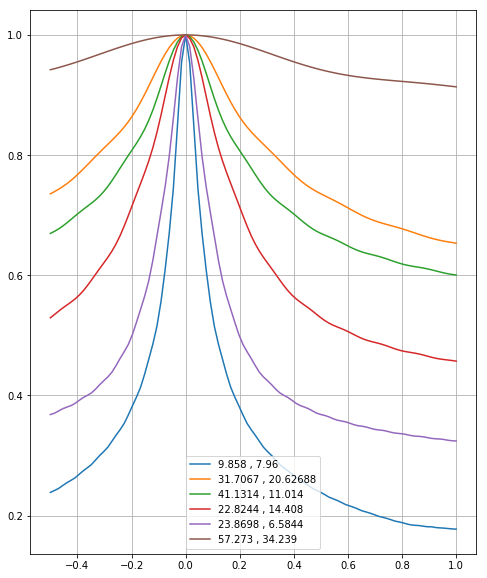

In [2]:
#reproduce top right figure 11 from Mohini's thesis
#delta phi = (-0.5 to 0.1)
plt.figure(figsize=(8, 10))

mass1 = [9.858, 31.7067, 41.1314, 22.8244, 23.8698, 57.273]
mass2 = [7.96, 20.62688, 11.014, 14.408, 6.5844, 34.239]
i = 0
for i in range(len(mass1)):
    op = []
    tmp_params = copy.deepcopy(lsu.ChooseWaveformParams())
    tmp_params.mass1 = mass1[i]
    tmp_params.mass2 = mass2[i]
    tmp_params.spin1z = 0.998
    tmp_params.spin2z = 0.998

    for delta_phi1 in np.linspace(-0.5, 1, 100):
        inj_params = copy.deepcopy(lsu.ChooseWaveformParams())
        inj_params.mass1 = mass1[i]
        inj_params.mass2 = mass2[i]
        inj_params.spin1z = 0.998
        inj_params.spin2z = 0.998
        lal_prm = lal.CreateDict()
        lalsim.SimInspiralWaveformParamsInsertNonGRDChi1(lal_prm, delta_phi1) # maximum 2.5
        lalsim.SimInspiralWaveformParamsInsertNonGRDChi2(lal_prm, 0.0) # maximum 5.5 
        lalsim.SimInspiralWaveformParamsInsertNonGRDChi3(lal_prm, 0.0) # maximum 5.5
        lalsim.SimInspiralWaveformParamsInsertNonGRDChi4(lal_prm, 0.0) # maximum 5.5 

        inj_params.nonGRparams = lal_prm

        PSD = get_PSD(inj_params.deltaF, inj_params.fmin, inj_params.fmax, noise_models["aLIGOZeroDetHighPower"])
        ASD = np.sqrt(PSD)

        op.append(CalMatch(tmp_params, inj_params, ASD))
    
    plt.plot(np.linspace(-0.5, 1, 100) ,op, label = str(mass1[i])+ " , " +str(mass2[i]) )
    i = i+1



plt.grid()
plt.legend()
plt.show()

#In Mohini's graph the stepsize is big. 


In [3]:
#inject waveforms in the template bank and find the fitting factor
#plot various combinations of generated template bank
#couldn't access the clustera